Data can be download from [kraggle](https://www.kaggle.com/c/home-credit-default-risk/data) or directly [here](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip). The projet concern a scoring score about cease of payment. Interactif dashboards are also present to understand the parameters behind the algorithm and the reason behind a refusal. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [2]:
def distance_IQ(dt, q1=0.25, q3=0.75, return_flag = False):
    """
    Compute interquantile value and return number
    of elements 
        * Above Q3 + 1.5*IQ
        * Bellow Q1 - 1*5 IQ
    Arguments:
        _dt: dataFrame (pandas)
        _q1: first quantile (default 0.25)
        _q3: third quantile (default 0.75)
    """
    q1 = dt.quantile(q1)
    q3 = dt.quantile(q3)
    IQ = q3-q1
    count = dt[dt < q1 - 1.5* IQ ].count() 
    print("Element {0} bellow Q1 - 1.5 * IQ ({1:.2f})".format(count, q1 - 1.5* IQ))
    count = dt[dt > q3 + 1.5* IQ ].count() 
    print("Element {0} above Q3 + 1.5 * IQ ({1:.2f})".format(count ,q3 + 1.5 * IQ))
    if return_flag:
        return q1 - 1.5* IQ, q3 + 1.5* IQ

In [3]:
def clean_IQ(dt, lab, q1=0.25, q3=0.75):
    borne_inf, borne_sup = distance_IQ(dt[lab], q1=0.25, q3=0.75, return_flag = True)
    if borne_inf - borne_sup == 0:
        print("distance IQ = 0")
        return dt
    if borne_inf is not None:
        dt = dt[dt[lab] > borne_inf]
    if borne_sup is not None:
        dt = dt[dt[lab] < borne_sup]
    return dt

# Load data



In [4]:
df_test = pd.read_csv('application_test.csv')
df_train = pd.read_csv('application_train.csv')
df_bureau = pd.read_csv('bureau.csv')
df_bureau_balance = pd.read_csv('bureau_balance.csv')
df_credit_balance = pd.read_csv('credit_card_balance.csv')
df_home_credit = pd.read_csv("HomeCredit_columns_description.csv", encoding = "ISO-8859-1")
df_installments_payments = pd.read_csv("installments_payments.csv")
df_POS_CASH_balance = pd.read_csv("POS_CASH_balance.csv")
df_previous_application = pd.read_csv("previous_application.csv")
df_sample_submission = pd.read_csv("sample_submission.csv")

### Test

In [5]:
df_test.head(3)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.066,0.059,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.059,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0


### Train

In [6]:
df_train.head(3)
#This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
#Static data for all applications. One row represents one loan in our data sample.

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [7]:
df_train["SK_ID_CURR"].nunique()

307511

In [8]:
df_train.shape

(307511, 122)

In [9]:
data_train = df_train[["SK_ID_CURR", "TARGET", "NAME_CONTRACT_TYPE", 
                      "CODE_GENDER", "FLAG_OWN_CAR", "FLAG_OWN_REALTY",
                        "AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY",
                       "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", 
                       "NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE",
                      "DAYS_BIRTH", "DAYS_EMPLOYED", "OWN_CAR_AGE",
                      "OCCUPATION_TYPE", "CNT_FAM_MEMBERS"]]

In [10]:
print(df_home_credit.loc[df_home_credit["Row"] == "LANDAREA_MODE", "Description"].values)

['Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor']


In [11]:
print(df_home_credit.loc[df_home_credit["Row"] == "TARGET", "Description"].values)

['Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)']


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F41A1ECD88>]],
      dtype=object)

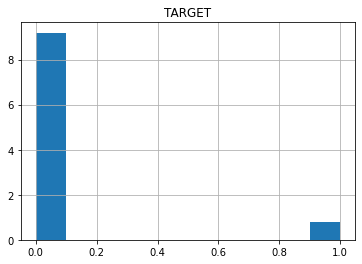

In [12]:
data_train.hist("TARGET", density=1)

#### OCCUPATION_TYPE

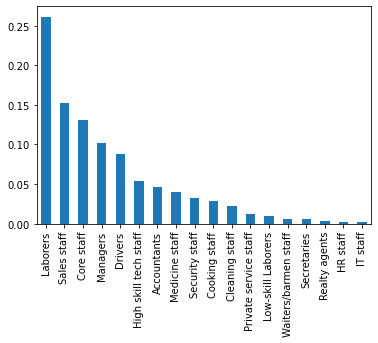

In [13]:
data_train["OCCUPATION_TYPE"].value_counts(normalize = True).plot.bar()

In [14]:
print(df_home_credit.loc[df_home_credit["Row"] == "OCCUPATION_TYPE", "Description"].values)

['What kind of occupation does the client have']


#### DAYS_EMPLOYED

In [15]:
print(df_home_credit.loc[df_home_credit["Row"] == "DAYS_EMPLOYED", "Description"].values)

['How many days before the application the person started current employment']


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F434F3A488>]],
      dtype=object)

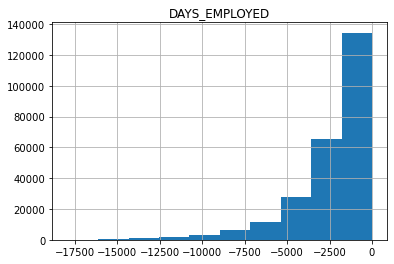

In [16]:
data_train[data_train["DAYS_EMPLOYED"] < 50000].hist("DAYS_EMPLOYED")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F434FCC808>]],
      dtype=object)

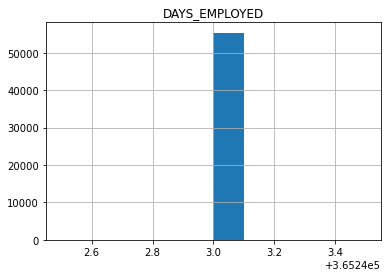

In [17]:
data_train[(data_train["DAYS_EMPLOYED"] >0) & (data_train["DAYS_EMPLOYED"] < 500000)].hist("DAYS_EMPLOYED")

**300 000 jours correspond à plus de 87 ans de travail**. On supprime les valeurs positives

In [18]:
#distance_IQ(data_train["DAYS_EMPLOYED"])
data_train = clean_IQ(data_train, "DAYS_EMPLOYED")

Element 16843 bellow Q1 - 1.5 * IQ (-6466.50)
Element 55374 above Q3 + 1.5 * IQ (3417.50)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F434FF19C8>]],
      dtype=object)

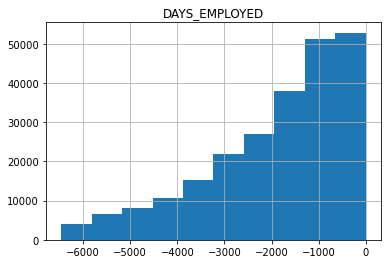

In [19]:
data_train.hist("DAYS_EMPLOYED")

#### NAME_CONTRACT_TYPE

In [20]:
data_train["NAME_CONTRACT_TYPE"].value_counts()

Cash loans         210803
Revolving loans     24491
Name: NAME_CONTRACT_TYPE, dtype: int64

#### CODE_GENDER

In [21]:
data_train["CODE_GENDER"].value_counts()

F      144488
M       90803
XNA         3
Name: CODE_GENDER, dtype: int64

On retire le genre indéfini pour éviter de futur biais.

In [22]:
data_train = data_train[df_train["CODE_GENDER"] != "XNA"]

c:\users\jayse\pymol\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


#### AMT_INCOME_TOTAL

In [23]:
print(df_home_credit.loc[df_home_credit["Row"] == "AMT_INCOME_TOTAL", "Description"].values)

['Income of the client']


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F41A7D55C8>]],
      dtype=object)

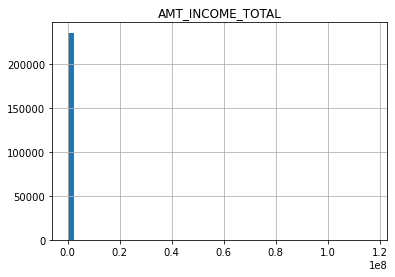

In [24]:
data_train.hist("AMT_INCOME_TOTAL", bins = 50)

In [25]:
data_train["AMT_INCOME_TOTAL"].describe()

count    2.352910e+05
mean     1.758691e+05
std      2.658991e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.575000e+05
75%      2.115000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64

3/4 of customers earn less than 200 000 $. One individu earn more than 10 millions dollars. 

Element 0 bellow Q1 - 1.5 * IQ (-36000.00)
Element 8149 above Q3 + 1.5 * IQ (360000.00)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F41A8074C8>]],
      dtype=object)

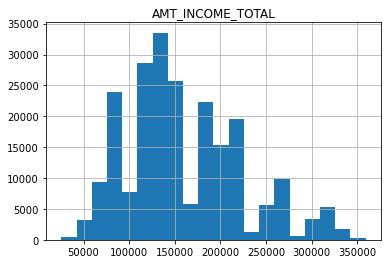

In [26]:
data_train = clean_IQ(data_train, "AMT_INCOME_TOTAL")
data_train.hist("AMT_INCOME_TOTAL", bins = 20)

#### AMT_CREDIT

In [27]:
print(df_home_credit.loc[df_home_credit["Row"] == "AMT_CREDIT", "Description"].values)

['Credit amount of the loan'
 'Final credit amount on the previous application. This differs from AMT_APPLICATION in a way that the AMT_APPLICATION is the amount for which the client initially applied for, but during our approval process he could have received different amount - AMT_CREDIT']


In [28]:
#data_train.hist("AMT_CREDIT", bins= 50)

Element 0 bellow Q1 - 1.5 * IQ (-537975.00)
Element 3713 above Q3 + 1.5 * IQ (1616625.00)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F41A953088>]],
      dtype=object)

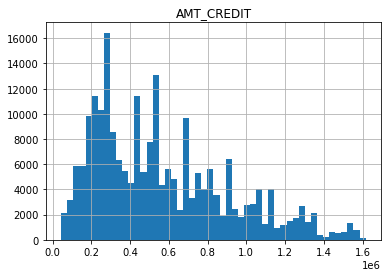

In [29]:
data_train = clean_IQ(data_train, "AMT_CREDIT")
data_train.hist("AMT_CREDIT", bins = 50)

#### AMT_ANNUITY

In [30]:
print(df_home_credit.loc[df_home_credit["Row"] == "AMT_ANNUITY", "Description"].values)

['Loan annuity' 'Annuity of the Credit Bureau credit'
 'Annuity of previous application']


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F41A9C1588>]],
      dtype=object)

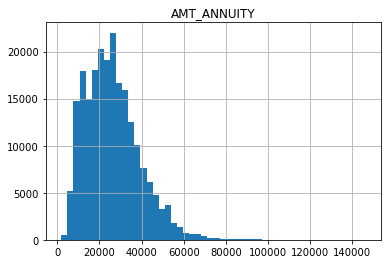

In [31]:
data_train.hist("AMT_ANNUITY", bins= 50)

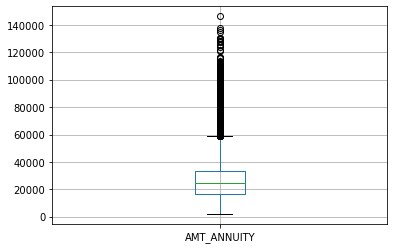

In [32]:
data_train.boxplot("AMT_ANNUITY")

Element 0 bellow Q1 - 1.5 * IQ (-8797.50)
Element 3624 above Q3 + 1.5 * IQ (58882.50)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F41B802CC8>]],
      dtype=object)

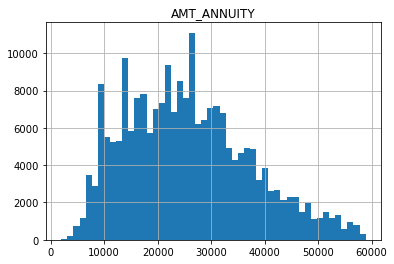

In [33]:
data_train = clean_IQ(data_train, "AMT_ANNUITY")
data_train.hist("AMT_ANNUITY", bins = 50)

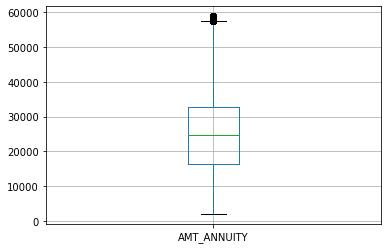

In [34]:
data_train.boxplot("AMT_ANNUITY")

#### AMT_REQ_CREDIT_BUREAU_X

In [35]:
print(df_home_credit.loc[df_home_credit["Row"] == "AMT_REQ_CREDIT_BUREAU_HOUR", "Description"].values)

['Number of enquiries to Credit Bureau about the client one hour before application']


In [36]:
print(df_home_credit.loc[df_home_credit["Row"] == "AMT_REQ_CREDIT_BUREAU_DAY", "Description"].values)

['Number of enquiries to Credit Bureau about the client one day before application (excluding one hour before application)']


In [37]:
print(df_home_credit.loc[df_home_credit["Row"] == "FLAG_OWN_REALTY", "Description"].values)

['Flag if client owns a house or flat']


#### good data

In [38]:
data_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,100002,1,Cash loans,M,N,Y,202500.0,406597.5,24700.5,Working,Secondary / secondary special,Single / not married,House / apartment,-9461,-637,NaN,Laborers,1.0
1,100003,0,Cash loans,F,N,N,270000.0,1293502.5,35698.5,State servant,Higher education,Married,House / apartment,-16765,-1188,NaN,Core staff,2.0
2,100004,0,Revolving loans,M,Y,Y,67500.0,135000.0,6750.0,Working,Secondary / secondary special,Single / not married,House / apartment,-19046,-225,26.0,Laborers,1.0
3,100006,0,Cash loans,F,N,Y,135000.0,312682.5,29686.5,Working,Secondary / secondary special,Civil marriage,House / apartment,-19005,-3039,NaN,Laborers,2.0
4,100007,0,Cash loans,M,N,Y,121500.0,513000.0,21865.5,Working,Secondary / secondary special,Single / not married,House / apartment,-19932,-3038,NaN,Core staff,1.0


In [39]:
data_train.shape

(216220, 18)

In [40]:
def proportion_info(label):
    print("\n\tAll data for "+label)
    print(data_train[label].value_counts(normalize = True) *100)
    print("\n\tAcepted loan")
    print(data_train[data_train["TARGET"] == 0][label].value_counts(normalize = True) *100)
    print("\n\tRejeted loan")
    print(data_train[data_train["TARGET"] == 1][label].value_counts(normalize = True) *100)

In [41]:
for label in ["NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "FLAG_OWN_CAR", "FLAG_OWN_REALTY",
               "NAME_FAMILY_STATUS", "NAME_CONTRACT_TYPE", "CODE_GENDER", 'NAME_HOUSING_TYPE',
               'OCCUPATION_TYPE']:
    proportion_info(label)


	All data for NAME_INCOME_TYPE
Working                 64.826103
Commercial associate    27.462769
State servant            7.697715
Student                  0.006937
Pensioner                0.003237
Maternity leave          0.001850
Businessman              0.001387
Name: NAME_INCOME_TYPE, dtype: float64

	Acepted loan
Working                 64.223868
Commercial associate    27.830071
State servant            7.932302
Student                  0.007644
Pensioner                0.003567
Businessman              0.001529
Maternity leave          0.001019
Name: NAME_INCOME_TYPE, dtype: float64

	Rejeted loan
Working                 70.735610
Commercial associate    23.858579
State servant            5.395809
Maternity leave          0.010002
Name: NAME_INCOME_TYPE, dtype: float64

	All data for NAME_EDUCATION_TYPE
Secondary / secondary special    70.595227
Higher education                 24.343724
Incomplete higher                 4.038479
Lower secondary                   0.974933
Ac

In [42]:
data_train = data_train.drop(["NAME_INCOME_TYPE", "NAME_HOUSING_TYPE",
                              "FLAG_OWN_CAR", "FLAG_OWN_REALTY",], axis = 1)

In [43]:
# change some labels
ind = data_train['NAME_EDUCATION_TYPE'] == "Lower secondary"
data_train.loc[ind, ['NAME_EDUCATION_TYPE']] = "Other"
ind = data_train['NAME_EDUCATION_TYPE'] == "Academic degree"
data_train.loc[ind, ['NAME_EDUCATION_TYPE']] = "Other"

In [44]:
#Remove Unknown status for family
ind = data_train['NAME_FAMILY_STATUS'] == "Unknown"
data_train = data_train[~ind]

In [45]:
data_train.loc[ind, 'OCCUPATION_TYPE']

Series([], Name: OCCUPATION_TYPE, dtype: object)

In [46]:
for col in ["Low-skill Laborers", "Waiters/barmen staff", "Secretaries", "Cooking staff", "Cleaning staff", "Security staff"]:
    ind = data_train["OCCUPATION_TYPE"] == col
    data_train.loc[ind, 'OCCUPATION_TYPE'] = "Other"
proportion_info("OCCUPATION_TYPE")


	All data for OCCUPATION_TYPE
Laborers                 27.001909
Sales staff              16.680831
Core staff               12.422048
Other                    11.282988
Drivers                   9.198022
Managers                  8.070551
High skill tech staff     5.118597
Accountants               4.468494
Medicine staff            3.623580
Private service staff     1.277028
Realty agents             0.373616
HR staff                  0.252205
IT staff                  0.230130
Name: OCCUPATION_TYPE, dtype: float64

	Acepted loan
Laborers                 26.474242
Sales staff              16.601510
Core staff               12.762757
Other                    11.049811
Drivers                   8.954451
Managers                  8.318110
High skill tech staff     5.274023
Accountants               4.679698
Medicine staff            3.697479
Private service staff     1.312873
Realty agents             0.378151
HR staff                  0.261235
IT staff                  0.235659
Name: 

In [47]:
data_train =pd.get_dummies(data_train, columns=["NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS", "NAME_CONTRACT_TYPE", 
                                    "CODE_GENDER", 'OCCUPATION_TYPE'], drop_first=False)

In [48]:
data_train.shape

(216219, 35)

In [49]:
data_train.head()

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,CNT_FAM_MEMBERS,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Other,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Other,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff
0,100002,1,202500.0,406597.5,24700.5,-9461,-637,NaN,1.0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,100003,0,270000.0,1293502.5,35698.5,-16765,-1188,NaN,2.0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,100004,0,67500.0,135000.0,6750.0,-19046,-225,26.0,1.0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
3,100006,0,135000.0,312682.5,29686.5,-19005,-3039,NaN,2.0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,100007,0,121500.0,513000.0,21865.5,-19932,-3038,NaN,1.0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0


#### Customer age & days employed

In [50]:
data_train["DAYS_BIRTH"] = data_train["DAYS_BIRTH"]/-364.5
data_train = data_train.rename(columns={"DAYS_BIRTH": "AGE"})
data_train["DAYS_EMPLOYED"] = data_train["DAYS_EMPLOYED"]/-364.5
data_train = data_train.rename(columns={"DAYS_EMPLOYED": "YEARS_EMPLOYED"})


## Bureau

In [51]:
df_bureau.head(3)
#All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
#For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN


In [52]:
good_bureau = df_bureau[["SK_ID_CURR", "SK_ID_BUREAU", "CREDIT_ACTIVE", "CREDIT_CURRENCY", 
                         "DAYS_CREDIT", "CREDIT_DAY_OVERDUE", "DAYS_CREDIT_ENDDATE", 
                         "DAYS_ENDDATE_FACT", "AMT_CREDIT_MAX_OVERDUE", "CNT_CREDIT_PROLONG", 
                         "AMT_CREDIT_SUM", "AMT_CREDIT_SUM_DEBT"]]

In [53]:
good_bureau.shape

(1716428, 12)

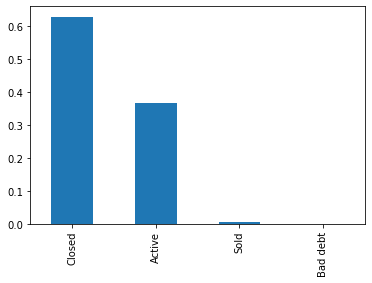

In [54]:
good_bureau["CREDIT_ACTIVE"].value_counts(normalize = True).plot.bar()

In [55]:
print(df_home_credit.loc[df_home_credit["Row"] == "CREDIT_CURRENCY", "Description"].values)

['Recoded currency of the Credit Bureau credit']


In [56]:
print(df_home_credit.loc[df_home_credit["Row"] == "CREDIT_DAY_OVERDUE", "Description"].values)

['Number of days past due on CB credit at the time of application for related loan in our sample']


In [57]:
good_bureau["CREDIT_DAY_OVERDUE"].describe()

count    1.716428e+06
mean     8.181666e-01
std      3.654443e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.792000e+03
Name: CREDIT_DAY_OVERDUE, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F41AF3C508>]],
      dtype=object)

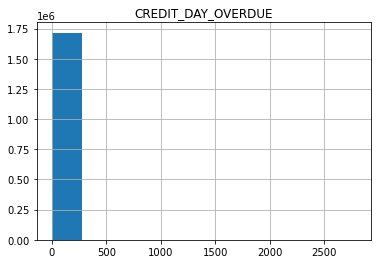

In [58]:
good_bureau.hist("CREDIT_DAY_OVERDUE")

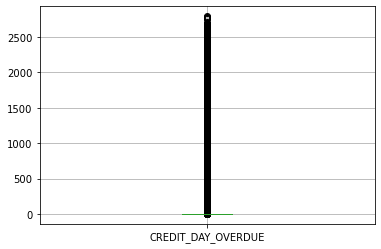

In [59]:
good_bureau.boxplot('CREDIT_DAY_OVERDUE')

In [60]:
good_bureau = clean_IQ(good_bureau, "CREDIT_DAY_OVERDUE")

Element 0 bellow Q1 - 1.5 * IQ (0.00)
Element 4217 above Q3 + 1.5 * IQ (0.00)
distance IQ = 0


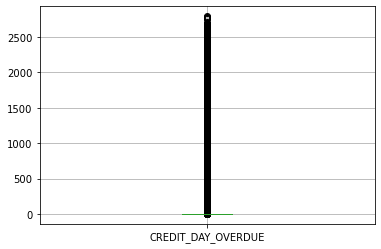

In [61]:
good_bureau.boxplot('CREDIT_DAY_OVERDUE')

### Moyenne des crédits et durée

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F435093FC8>]],
      dtype=object)

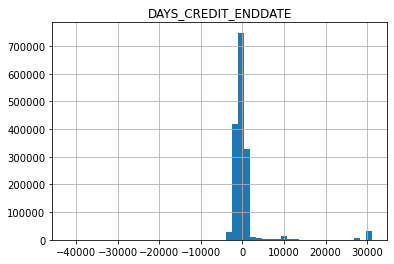

In [62]:
good_bureau.hist("DAYS_CREDIT_ENDDATE", bins = 50)

In [63]:
good_bureau["DAYS_CREDIT_ENDDATE"].describe()

count    1.610875e+06
mean     5.105174e+02
std      4.994220e+03
min     -4.206000e+04
25%     -1.138000e+03
50%     -3.300000e+02
75%      4.740000e+02
max      3.119900e+04
Name: DAYS_CREDIT_ENDDATE, dtype: float64

In [64]:
good_bureau = clean_IQ(good_bureau, "DAYS_CREDIT_ENDDATE")

Element 149 bellow Q1 - 1.5 * IQ (-3556.00)
Element 79191 above Q3 + 1.5 * IQ (2892.00)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F4350F4A48>]],
      dtype=object)

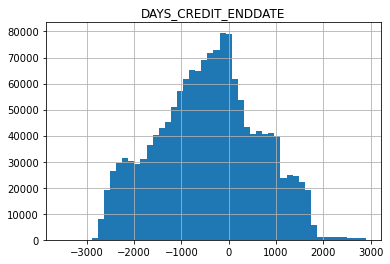

In [65]:
good_bureau.hist("DAYS_CREDIT_ENDDATE", bins = 50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F43529BF08>]],
      dtype=object)

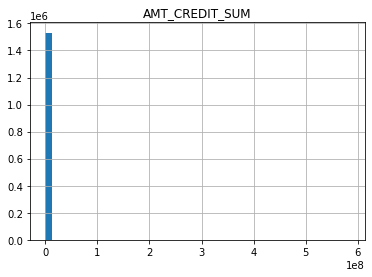

In [66]:
good_bureau.hist("AMT_CREDIT_SUM", bins = 50)

In [67]:
good_bureau = clean_IQ(good_bureau, "AMT_CREDIT_SUM")

Element 0 bellow Q1 - 1.5 * IQ (-336375.00)
Element 168633 above Q3 + 1.5 * IQ (698625.00)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F435295848>]],
      dtype=object)

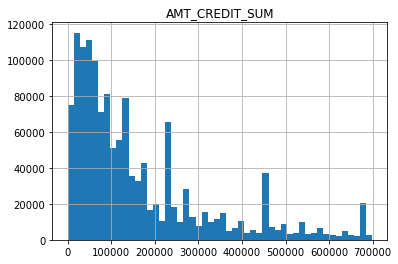

In [68]:
good_bureau.hist("AMT_CREDIT_SUM", bins = 50)

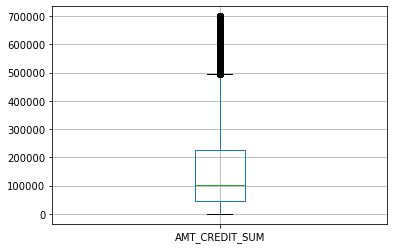

In [69]:
good_bureau.boxplot("AMT_CREDIT_SUM")

In [70]:
distance_IQ(good_bureau["AMT_CREDIT_SUM"])

Element 0 bellow Q1 - 1.5 * IQ (-223604.16)
Element 76743 above Q3 + 1.5 * IQ (494162.49)


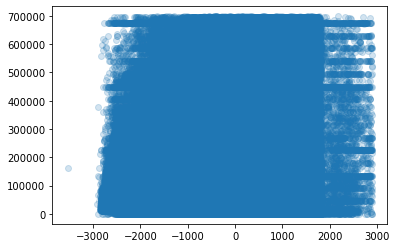

In [71]:
y = good_bureau["AMT_CREDIT_SUM"].to_numpy()
x = good_bureau["DAYS_CREDIT_ENDDATE"].to_numpy()
plt.scatter(x, y, alpha = 0.2)

In [72]:
print(df_home_credit.loc[df_home_credit["Row"] == "CREDIT_ACTIVE", "Description"].values)

['Status of the Credit Bureau (CB) reported credits']


In [73]:
good_bureau["CREDIT_ACTIVE"].value_counts()
#keep only row whith recent update

Closed      955455
Active      403089
Sold          4328
Bad debt        20
Name: CREDIT_ACTIVE, dtype: int64

In [74]:
print(df_home_credit.loc[df_home_credit["Row"] == "CREDIT_CURRENCY", "Description"].values)

['Recoded currency of the Credit Bureau credit']


In [75]:
good_bureau["CREDIT_CURRENCY"].value_counts()
#keep only row whith recent update

currency 1    1362544
currency 2        265
currency 3         81
currency 4          2
Name: CREDIT_CURRENCY, dtype: int64

In [76]:
print(df_home_credit.loc[df_home_credit["Row"] == "DAYS_CREDIT", "Description"].values)

['How many days before current application did client apply for Credit Bureau credit']


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F4A5445588>]],
      dtype=object)

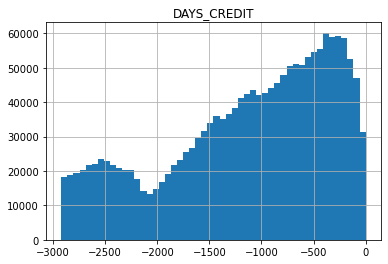

In [77]:
df_bureau.hist("DAYS_CREDIT", bins = 50)
#keep only row whith recent update

In [78]:
print(df_home_credit.loc[df_home_credit["Row"] == "DAYS_CREDIT_ENDDATE", "Description"].values)

['Remaining duration of CB credit (in days) at the time of application in Home Credit']


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F4A547E588>]],
      dtype=object)

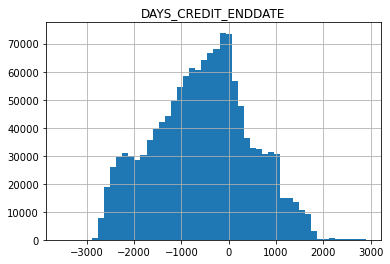

In [79]:
good_bureau.hist("DAYS_CREDIT_ENDDATE", bins = 50)

In [80]:
print(df_home_credit.loc[df_home_credit["Row"] == "DAYS_ENDDATE_FACT", "Description"].values)

['Days since CB credit ended at the time of application in Home Credit (only for closed credit)']


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F4A5765448>]],
      dtype=object)

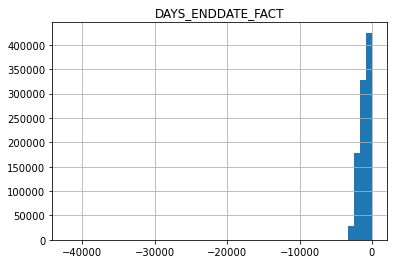

In [81]:
good_bureau.hist("DAYS_ENDDATE_FACT", bins = 50)

In [82]:
print(df_home_credit.loc[df_home_credit["Row"] == "AMT_CREDIT_SUM_DEBT", "Description"].values)

['Current debt on Credit Bureau credit']


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F4A584C988>]],
      dtype=object)

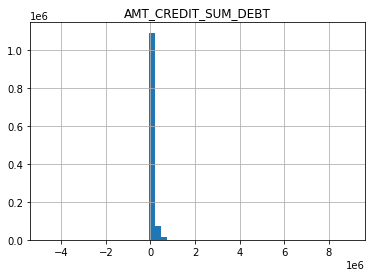

In [83]:
good_bureau.hist("AMT_CREDIT_SUM_DEBT", bins = 50)

In [84]:
good_bureau.shape

(1362892, 12)

In [85]:
good_bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.00,0.0
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.00,171342.0
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.50,NaN
6,215354,5714468,Active,currency 1,-43,0,79.0,NaN,0.0,0,42103.80,42103.8
7,162297,5714469,Closed,currency 1,-1896,0,-1684.0,-1710.0,14985.0,0,76878.45,0.0


In [86]:
good_bureau = pd.get_dummies(good_bureau, columns=["CREDIT_ACTIVE", "CREDIT_CURRENCY"])

In [87]:
good_bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4
0,215354,5714462,-497,0,-153.0,-153.0,NaN,0,91323.00,0.0,0,0,1,0,1,0,0,0
1,215354,5714463,-208,0,1075.0,NaN,NaN,0,225000.00,171342.0,1,0,0,0,1,0,0,0
2,215354,5714464,-203,0,528.0,NaN,NaN,0,464323.50,NaN,1,0,0,0,1,0,0,0
6,215354,5714468,-43,0,79.0,NaN,0.0,0,42103.80,42103.8,1,0,0,0,1,0,0,0
7,162297,5714469,-1896,0,-1684.0,-1710.0,14985.0,0,76878.45,0.0,0,0,1,0,1,0,0,0


In [88]:
print(df_home_credit.loc[df_home_credit["Row"] == "AMT_CREDIT_SUM_DEBT", "Description"].values)

['Current debt on Credit Bureau credit']


### Sous tableau informations des crédits en cours

In [89]:
bureau_credit_active = good_bureau[good_bureau["CREDIT_ACTIVE_Active"] == 1]
tmp = bureau_credit_active[["SK_ID_CURR", "CREDIT_ACTIVE_Active"]].groupby(["SK_ID_CURR"]).sum()
tmp2 = bureau_credit_active[["SK_ID_CURR", "AMT_CREDIT_MAX_OVERDUE", "AMT_CREDIT_SUM", ]].groupby(["SK_ID_CURR"]).mean()
bureau_credit_active = tmp.merge(tmp2, how = "left", on = "SK_ID_CURR")
bureau_credit_active["AMT_CREDIT_MAX_OVERDUE"] = bureau_credit_active["AMT_CREDIT_MAX_OVERDUE"].fillna(0)

In [90]:
#rename columns
tmp = bureau_credit_active["AMT_CREDIT_MAX_OVERDUE"]/bureau_credit_active["AMT_CREDIT_SUM"]
tmp = tmp.reset_index().rename(columns={0 : "proportion_OVERDUE_active"})
bureau_credit_active = bureau_credit_active.rename(columns={"AMT_CREDIT_MAX_OVERDUE": "CREDIT_MEAN_OVERDUE_active",
                                                            "CREDIT_ACTIVE_Active" : "CREDIT_active",
                                                            "AMT_CREDIT_SUM": "CREDIT_MEAN_active"})
bureau_credit_active = bureau_credit_active.reset_index()
bureau_credit_active = bureau_credit_active.merge(tmp, on ="SK_ID_CURR", how = "left")

### Sous tableau informations des crédits fermés

In [91]:
bureau_credit_closed = good_bureau[good_bureau["CREDIT_ACTIVE_Closed"] == 1]
tmp = bureau_credit_closed[["SK_ID_CURR", "CREDIT_ACTIVE_Closed"]].groupby(["SK_ID_CURR"]).sum()
tmp2 = bureau_credit_closed[["SK_ID_CURR", "AMT_CREDIT_MAX_OVERDUE", "AMT_CREDIT_SUM", ]].groupby(["SK_ID_CURR"]).mean()
bureau_credit_closed = tmp.merge(tmp2, how = "left", on = "SK_ID_CURR")
bureau_credit_closed["AMT_CREDIT_MAX_OVERDUE"] = bureau_credit_closed["AMT_CREDIT_MAX_OVERDUE"].fillna(0)

In [92]:
#rename columns
tmp = bureau_credit_closed["AMT_CREDIT_MAX_OVERDUE"]/bureau_credit_closed["AMT_CREDIT_SUM"]
tmp = tmp.reset_index().rename(columns={0 : "proportion_OVERDUE_closed"})
bureau_credit_closed = bureau_credit_closed.rename(columns={"AMT_CREDIT_MAX_OVERDUE": "CREDIT_MEAN_OVERDUE_closed",
                                                            "CREDIT_ACTIVE_Closed" : "CREDIT_closed",
                                                            "AMT_CREDIT_SUM": "CREDIT_MEAN_closed"})
bureau_credit_closed = bureau_credit_closed.reset_index()
bureau_credit_closed = bureau_credit_closed.merge(tmp, on ="SK_ID_CURR", how = "left")

In [93]:
bureau_credit_closed

,SK_ID_CURR,CREDIT_closed,CREDIT_MEAN_OVERDUE_closed,CREDIT_MEAN_closed,proportion_OVERDUE_closed
0,100001,4,0.00000,142335.000,0.000000
1,100002,5,2091.16125,76613.400,0.027295
2,100003,3,0.00000,69133.500,0.000000
3,100004,2,0.00000,94518.900,0.000000
4,100005,1,0.00000,58500.000,0.000000
...,...,...,...,...,...
257878,456249,9,15367.50000,245428.740,0.062615
257879,456250,1,0.00000,483349.500,0.000000
257880,456253,2,0.00000,675000.000,0.000000
257881,456254,1,0.00000,45000.000,0.000000


### Sous tableau informations des crédits vendus

In [94]:
bureau_credit_sold = good_bureau[good_bureau["CREDIT_ACTIVE_Sold"] == 1]
tmp = bureau_credit_sold[["SK_ID_CURR", "CREDIT_ACTIVE_Sold"]].groupby(["SK_ID_CURR"]).sum()
tmp2 = bureau_credit_sold[["SK_ID_CURR", "AMT_CREDIT_MAX_OVERDUE", "AMT_CREDIT_SUM", ]].groupby(["SK_ID_CURR"]).mean()
bureau_credit_sold = tmp.merge(tmp2, how = "left", on = "SK_ID_CURR")
bureau_credit_sold["AMT_CREDIT_MAX_OVERDUE"] = bureau_credit_sold["AMT_CREDIT_MAX_OVERDUE"].fillna(0)

In [95]:
#rename columns
tmp = bureau_credit_sold["AMT_CREDIT_MAX_OVERDUE"]/bureau_credit_sold["AMT_CREDIT_SUM"]
tmp = tmp.reset_index().rename(columns={0 : "proportion_OVERDUE_sold"})
bureau_credit_sold = bureau_credit_sold.rename(columns={"AMT_CREDIT_MAX_OVERDUE": "CREDIT_MEAN_OVERDUE_sold",
                                                            "CREDIT_ACTIVE_Sold" : "CREDIT_sold",
                                                            "AMT_CREDIT_SUM": "CREDIT_MEAN_sold"})
bureau_credit_sold = bureau_credit_sold.reset_index()
bureau_credit_sold = bureau_credit_sold.merge(tmp, on ="SK_ID_CURR", how = "left")

### Sous tableau informations des mauvais crédits

In [96]:
bureau_credit_bad_debt = good_bureau[good_bureau["CREDIT_ACTIVE_Bad debt"] == 1]
tmp = bureau_credit_bad_debt[["SK_ID_CURR", "CREDIT_ACTIVE_Bad debt"]].groupby(["SK_ID_CURR"]).sum()
tmp2 = bureau_credit_bad_debt[["SK_ID_CURR", "AMT_CREDIT_MAX_OVERDUE", "AMT_CREDIT_SUM", ]].groupby(["SK_ID_CURR"]).mean()
bureau_credit_bad_debt = tmp.merge(tmp2, how = "left", on = "SK_ID_CURR")
bureau_credit_bad_debt["AMT_CREDIT_MAX_OVERDUE"] = bureau_credit_bad_debt["AMT_CREDIT_MAX_OVERDUE"].fillna(0)

In [97]:
#rename columns
tmp = bureau_credit_bad_debt["AMT_CREDIT_MAX_OVERDUE"]/bureau_credit_bad_debt["AMT_CREDIT_SUM"]
tmp = tmp.reset_index().rename(columns={0 : "proportion_OVERDUE_bad"})
bureau_credit_bad_debt = bureau_credit_bad_debt.rename(columns={"AMT_CREDIT_MAX_OVERDUE": "CREDIT_MEAN_OVERDUE_bad",
                                                            "CREDIT_ACTIVE_Bad debt" : "CREDIT_bad",
                                                            "AMT_CREDIT_SUM": "CREDIT_MEAN_bad"})
bureau_credit_bad_debt = bureau_credit_bad_debt.reset_index()
bureau_credit_bad_debt = bureau_credit_bad_debt.merge(tmp, on ="SK_ID_CURR", how = "left")

### Merge tableau

In [98]:
data_train = data_train.merge(bureau_credit_active, on='SK_ID_CURR', how='left')
data_train = data_train.merge(bureau_credit_sold, on='SK_ID_CURR', how='left')
data_train = data_train.merge(bureau_credit_closed, on='SK_ID_CURR', how='left')
data_train = data_train.merge(bureau_credit_bad_debt, on='SK_ID_CURR', how='left')

In [99]:
for col in data_train.columns[36:]:
    data_train[col] = data_train[col].fillna(0)

In [100]:
data_train.CREDIT_sold = data_train.CREDIT_sold / (data_train.CREDIT_sold +  data_train.CREDIT_closed + data_train.CREDIT_bad)
data_train.CREDIT_closed = data_train.CREDIT_closed / (data_train.CREDIT_sold +  data_train.CREDIT_closed + data_train.CREDIT_bad)
data_train.CREDIT_bad = data_train.CREDIT_bad / (data_train.CREDIT_sold +  data_train.CREDIT_closed + data_train.CREDIT_bad)

In [101]:
print(df_home_credit.loc[df_home_credit["Row"] == "AMT_CREDIT_MAX_OVERDUE", "Description"].values)

['Maximal amount overdue on the Credit Bureau credit so far (at application date of loan in our sample)']


In [102]:
print(df_home_credit.loc[df_home_credit["Row"] == "AMT_CREDIT_SUM", "Description"].values)

['Current credit amount for the Credit Bureau credit']


In [103]:
print(df_home_credit.loc[df_home_credit["Row"] == "AMT_CREDIT_SUM_DEBT", "Description"].values)

['Current debt on Credit Bureau credit']


In [104]:
bureau_credit_detail = good_bureau[["SK_ID_CURR", "CREDIT_DAY_OVERDUE", "DAYS_CREDIT_ENDDATE",
                "AMT_CREDIT_MAX_OVERDUE"]]

## Bureau balance

In [105]:
df_bureau_balance.head(3)
#Monthly balances of previous credits in Credit Bureau.
#This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has 
#(#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C


In [106]:
print(df_home_credit.loc[df_home_credit["Row"] == "MONTHS_BALANCE", "Description"].values)

['Month of balance relative to application date (-1 means the freshest balance date)'
 'Month of balance relative to application date (-1 means the information to the freshest monthly snapshot, 0 means the information at application - often it will be the same as -1 as many banks are not updating the information to Credit Bureau regularly )'
 'Month of balance relative to application date (-1 means the freshest balance date)']


In [107]:
print(df_home_credit.loc[df_home_credit["Row"] == "STATUS", "Description"].values)

['Status of Credit Bureau loan during the month (active, closed, DPD0-30,\x85 [C means closed, X means status unknown, 0 means no DPD, 1 means maximal did during month between 1-30, 2 means DPD 31-60,\x85 5 means DPD 120+ or sold or written off ] )']


## Crédit balance

In [108]:
print(df_home_credit.loc[df_home_credit["Row"] == "AMT_BALANCE", "Description"].values)

['Balance during the month of previous credit']


In [109]:
df_credit_balance.head(3)
#Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
#This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F4A5934388>]],
      dtype=object)

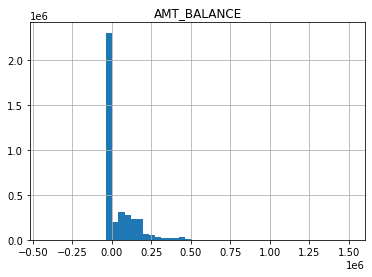

In [110]:
df_credit_balance.hist("AMT_BALANCE", bins = 50)

In [111]:
distance_IQ(df_credit_balance["AMT_BALANCE"])

Element 9 bellow Q1 - 1.5 * IQ (-133570.03)
Element 248137 above Q3 + 1.5 * IQ (222616.72)


In [112]:
print(df_home_credit.loc[df_home_credit["Row"] == "AMT_CREDIT_LIMIT_ACTUAL", "Description"].values)

['Credit card limit during the month of the previous credit']


In [113]:
print(df_home_credit.loc[df_home_credit["Row"] == "AMT_DRAWINGS_ATM_CURRENT", "Description"].values)

['Amount drawing at ATM during the month of the previous credit']


In [114]:
print(df_home_credit.loc[df_home_credit["Row"] == "NAME_CONTRACT_STATUS", "Description"].values)

['Contract status during the month'
 'Contract status (active signed,...) on the previous credit'
 'Contract status (approved, cancelled, ...) of previous application']


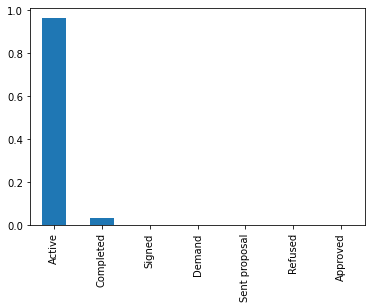

In [115]:
df_credit_balance["NAME_CONTRACT_STATUS"].value_counts(normalize = True).plot.bar()

In [116]:
print(df_home_credit.loc[df_home_credit["Row"] == "AMT_PAYMENT_TOTAL_CURRENT", "Description"].values)

['How much did the client pay during the month in total on the previous credit']


In [117]:
print(df_home_credit.loc[df_home_credit["Row"] == "AMT_TOTAL_RECEIVABLE", "Description"].values)

['Total amount receivable on the previous credit']


In [118]:
print(df_home_credit.loc[df_home_credit["Row"] == "MONTHS_BALANCE", "Description"].values)

['Month of balance relative to application date (-1 means the freshest balance date)'
 'Month of balance relative to application date (-1 means the information to the freshest monthly snapshot, 0 means the information at application - often it will be the same as -1 as many banks are not updating the information to Credit Bureau regularly )'
 'Month of balance relative to application date (-1 means the freshest balance date)']


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F4A5C054C8>]],
      dtype=object)

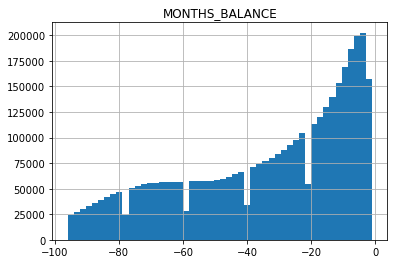

In [119]:
df_credit_balance.hist("MONTHS_BALANCE", bins = 50)

Data are not update every month. Most are older than 1 year.

In [120]:
print(df_home_credit.loc[df_home_credit["Row"] == "AMT_BALANCE", "Description"].values)

['Balance during the month of previous credit']


In [121]:
print(df_home_credit.loc[df_home_credit["Row"] == "AMT_CREDIT_LIMIT_ACTUAL", "Description"].values)

['Credit card limit during the month of the previous credit']


In [122]:
print(df_home_credit.loc[df_home_credit["Row"] == "AMT_DRAWINGS_CURRENT", "Description"].values)

['Amount drawing during the month of the previous credit']


In [123]:
print(df_home_credit.loc[df_home_credit["Row"] == "AMT_DRAWINGS_ATM_CURRENT", "Description"].values)

['Amount drawing at ATM during the month of the previous credit']


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F459EA5508>]],
      dtype=object)

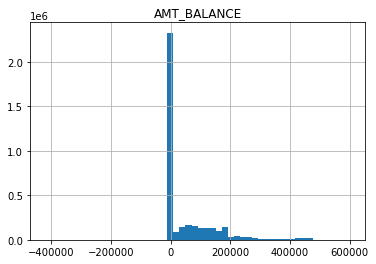

In [124]:
df_credit_balance[df_credit_balance["AMT_BALANCE"] < 600000].hist("AMT_BALANCE", bins = 50)
#df_credit_balance.hist("AMT_BALANCE", bins = 50)

In [125]:
print(df_home_credit.loc[df_home_credit["Row"] == "CNT_INSTALMENT_MATURE_CUM", "Description"].values)

['Number of paid installments on the previous credit']


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F4A10E7188>]],
      dtype=object)

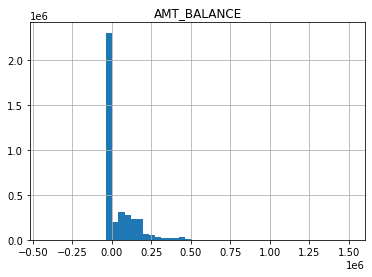

In [126]:
df_credit_balance.hist("AMT_BALANCE", bins = 50)

In [127]:
print(df_home_credit.loc[df_home_credit["Row"] == "AMT_CREDIT_LIMIT_ACTUAL", "Description"].values)

['Credit card limit during the month of the previous credit']


In [128]:
print(df_home_credit.loc[df_home_credit["Row"] == "AMT_DRAWINGS_ATM_CURRENT", "Description"].values)

['Amount drawing at ATM during the month of the previous credit']


In [129]:
print(df_home_credit.loc[df_home_credit["Row"] == "AMT_DRAWINGS_CURRENT", "Description"].values)

['Amount drawing during the month of the previous credit']


In [130]:
print(df_home_credit.loc[df_home_credit["Row"] == "AMT_DRAWINGS_OTHER_CURRENT", "Description"].values)

['Amount of other drawings during the month of the previous credit']


In [131]:
df_credit_balance.describe()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF
count,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,3.072324e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,3.840312e+06,3.840312e+06
mean,1.904504e+06,2.783242e+05,-3.452192e+01,5.830016e+04,1.538080e+05,5.961325e+03,7.433388e+03,2.881696e+02,2.968805e+03,3.540204e+03,1.028054e+04,7.588857e+03,5.596588e+04,5.808881e+04,5.809829e+04,3.094490e-01,7.031439e-01,4.812496e-03,5.594791e-01,2.082508e+01,9.283667e+00,3.316220e-01
std,5.364695e+05,1.027045e+05,2.666775e+01,1.063070e+05,1.651457e+05,2.822569e+04,3.384608e+04,8.201989e+03,2.079689e+04,5.600154e+03,3.607808e+04,3.200599e+04,1.025336e+05,1.059654e+05,1.059718e+05,1.100401e+00,3.190347e+00,8.263861e-02,3.240649e+00,2.005149e+01,9.751570e+01,2.147923e+01
min,1.000018e+06,1.000060e+05,-9.600000e+01,-4.202502e+05,0.000000e+00,-6.827310e+03,-6.211620e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.233058e+05,-4.202502e+05,-4.202502e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.434385e+06,1.895170e+05,-5.500000e+01,0.000000e+00,4.500000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.523700e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00
50%,1.897122e+06,2.783960e+05,-2.800000e+01,0.000000e+00,1.125000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.702700e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.500000e+01,0.000000e+00,0.000000e+00
75%,2.369328e+06,3.675800e+05,-1.100000e+01,8.904669e+04,1.800000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.633911e+03,9.000000e+03,6.750000e+03,8.535924e+04,8.889949e+04,8.891451e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00
max,2.843496e+06,4.562500e+05,-1.000000e+00,1.505902e+06,1.350000e+06,2.115000e+06,2.287098e+06,1.529847e+06,2.239274e+06,2.028820e+05,4.289207e+06,4.278316e+06,1.472317e+06,1.493338e+06,1.493338e+06,5.100000e+01,1.650000e+02,1.200000e+01,1.650000e+02,1.200000e+02,3.260000e+03,3.260000e+03


Element 9 bellow Q1 - 1.5 * IQ (-133570.03)
Element 248137 above Q3 + 1.5 * IQ (222616.72)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F4A11BF488>]],
      dtype=object)

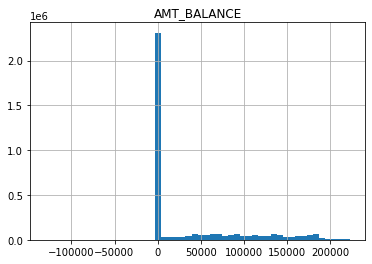

In [132]:
df_credit_balance = clean_IQ(df_credit_balance, "AMT_BALANCE")
df_credit_balance.hist("AMT_BALANCE", bins = 50)

Element 0 bellow Q1 - 1.5 * IQ (-157500.00)
Element 259147 above Q3 + 1.5 * IQ (382500.00)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F4A1295348>]],
      dtype=object)

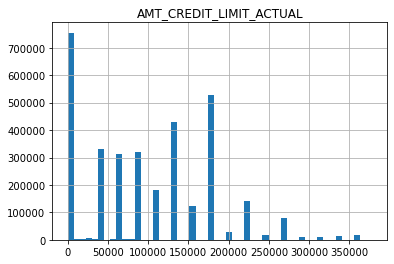

In [133]:
df_credit_balance = clean_IQ(df_credit_balance, "AMT_CREDIT_LIMIT_ACTUAL")
df_credit_balance.hist("AMT_CREDIT_LIMIT_ACTUAL", bins = 50)

In [134]:
tmp = df_credit_balance.groupby(['SK_ID_CURR','NAME_CONTRACT_STATUS']).mean().reset_index()[
    ["SK_ID_CURR", "NAME_CONTRACT_STATUS", "AMT_BALANCE", "AMT_CREDIT_LIMIT_ACTUAL"]
    ]
tmp2 = pd.DataFrame({"Ratio_Credit_limit" : tmp["AMT_BALANCE"]/tmp["AMT_CREDIT_LIMIT_ACTUAL"]})
good_balance = pd.concat([tmp[['SK_ID_CURR', "AMT_BALANCE", "AMT_CREDIT_LIMIT_ACTUAL"]], tmp2], axis=1)

In [135]:
good_balance['Ratio_Credit_limit'] = good_balance['Ratio_Credit_limit'].fillna(0)

In [136]:
good_balance.replace([np.inf, -np.inf], 0, inplace=True)
good_balance = good_balance.groupby("SK_ID_CURR").max().reset_index()

In [137]:
data_train.shape

(216219, 51)

In [138]:
data_train = data_train.merge(good_balance, on ="SK_ID_CURR", how = "left")

In [139]:
print(df_home_credit.loc[df_home_credit["Row"] == "AMT_BALANCE", "Description"].values)

['Balance during the month of previous credit']


## Home crédit

In [140]:
df_home_credit.head(10)
#explain label

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
5,8,application_{train|test}.csv,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
6,9,application_{train|test}.csv,CNT_CHILDREN,Number of children the client has,NaN
7,10,application_{train|test}.csv,AMT_INCOME_TOTAL,Income of the client,NaN
8,11,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan,NaN
9,12,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,NaN


## Installments payments

In [141]:
df_installments_payments.head(3)
#Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
#There is a) one row for every payment that was made plus b) one row each for missed payment.
#One row is equivalent to one payment of one installment OR one installment corresponding to one payment 
#of one previous Home Credit credit related to loans in our sample.

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000


In [142]:
df_installments_payments.shape

(13605401, 8)

## POS CASH balance

In [143]:
df_POS_CASH_balance.head(3)
#Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
#This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans)
#related to loans in our sample – i.e. the table has 
#(#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0


In [144]:
df_POS_CASH_balance.shape

(10001358, 8)

In [145]:
df_home_credit[142:150]

,Unnamed: 0,Table,Row,Description,Special
142,145,POS_CASH_balance.csv,SK_ID_PREV,ID of previous credit in Home Credit related t...,NaN
143,146,POS_CASH_balance.csv,SK_ID_CURR,ID of loan in our sample,NaN
144,147,POS_CASH_balance.csv,MONTHS_BALANCE,Month of balance relative to application date ...,time only relative to the application
145,148,POS_CASH_balance.csv,CNT_INSTALMENT,Term of previous credit (can change over time),NaN
146,149,POS_CASH_balance.csv,CNT_INSTALMENT_FUTURE,Installments left to pay on the previous credit,NaN
147,150,POS_CASH_balance.csv,NAME_CONTRACT_STATUS,Contract status during the month,NaN
148,151,POS_CASH_balance.csv,SK_DPD,DPD (days past due) during the month of previo...,NaN
149,152,POS_CASH_balance.csv,SK_DPD_DEF,DPD during the month with tolerance (debts wit...,NaN


## previous_application

In [146]:
df_previous_application.head(3)
#All previous applications for Home Credit loans of clients who have loans in our sample.
#There is one row for each previous application related to loans in our data sample.

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0


In [147]:
df_previous_application.shape

(1670214, 37)

In [148]:
print(df_home_credit.loc[df_home_credit["Row"] == "AMT_ANNUITY", "Description"].values)

['Loan annuity' 'Annuity of the Credit Bureau credit'
 'Annuity of previous application']


In [149]:
print(df_home_credit.loc[df_home_credit["Row"] == "AMT_APPLICATION", "Description"].values)

['For how much credit did client ask on the previous application']


In [150]:
print(df_home_credit.loc[df_home_credit["Row"] == "AMT_CREDIT", "Description"].values)

['Credit amount of the loan'
 'Final credit amount on the previous application. This differs from AMT_APPLICATION in a way that the AMT_APPLICATION is the amount for which the client initially applied for, but during our approval process he could have received different amount - AMT_CREDIT']


In [151]:
print(df_home_credit.loc[df_home_credit["Row"] == "AMT_INCOME_TOTAL", "Description"].values)

['Income of the client']


In [152]:
AMT_appli = df_previous_application[["SK_ID_CURR", "AMT_APPLICATION", "AMT_CREDIT"]].groupby("SK_ID_CURR").mean().reset_index()
AMT_appli = clean_IQ(AMT_appli, "AMT_CREDIT")

Element 0 bellow Q1 - 1.5 * IQ (-156076.88)
Element 21636 above Q3 + 1.5 * IQ (439906.12)


In [153]:
AMT_appli = AMT_appli.rename(columns = {"AMT_APPLICATION": "previous_APPLICATION", "AMT_CREDIT" : "previous_CREDIT"})
tmp = pd.DataFrame(data = AMT_appli["previous_CREDIT"]/AMT_appli["previous_APPLICATION"], columns=["ratio_ask_get"])
AMT_appli = pd.concat([AMT_appli, tmp] , axis = 1)
AMT_appli = AMT_appli.drop(["previous_APPLICATION"], axis = 1)
#replace NaN by 0
AMT_appli = AMT_appli.fillna(0)

In [154]:
data_train = data_train.merge(AMT_appli, on ="SK_ID_CURR", how = "left")

In [155]:
data_train.head()

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AGE,YEARS_EMPLOYED,OWN_CAR_AGE,CNT_FAM_MEMBERS,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Other,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Other,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,CREDIT_active,CREDIT_MEAN_OVERDUE_active,CREDIT_MEAN_active,proportion_OVERDUE_active,CREDIT_sold,CREDIT_MEAN_OVERDUE_sold,CREDIT_MEAN_sold,proportion_OVERDUE_sold,CREDIT_closed,CREDIT_MEAN_OVERDUE_closed,CREDIT_MEAN_closed,proportion_OVERDUE_closed,CREDIT_bad,CREDIT_MEAN_OVERDUE_bad,CREDIT_MEAN_bad,proportion_OVERDUE_bad,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,Ratio_Credit_limit,previous_CREDIT,ratio_ask_get
0,100002,1,202500.0,406597.5,24700.5,25.956104,1.747599,NaN,1.0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1.0,0.0,450000.0,0.0,0.0,0.0,0.0,0.0,1.0,2091.16125,76613.4,0.027295,0.0,0.0,0.0,0.0,NaN,NaN,NaN,179055.00,1.000000
1,100003,0,270000.0,1293502.5,35698.5,45.994513,3.259259,NaN,2.0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00000,69133.5,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,100004,0,67500.0,135000.0,6750.0,52.252401,0.617284,26.0,1.0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00000,94518.9,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,20106.00,0.828021
3,100006,0,135000.0,312682.5,29686.5,52.139918,8.337449,NaN,2.0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.00000,0.0,0.000000,NaN,0.0,0.0,0.0,0.0,270000.0,0.0,291695.50,1.071609
4,100007,0,121500.0,513000.0,21865.5,54.683128,8.334705,NaN,1.0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00000,146250.0,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,166638.75,1.107012


## sample submission

In [156]:
df_sample_submission.head(3)

,SK_ID_CURR,TARGET
0,100001,0.5
1,100005,0.5
2,100013,0.5


In [157]:
df_previous_application.shape

(1670214, 37)

In [158]:
tmp = pd.DataFrame(data_train["AMT_ANNUITY"] / data_train["AMT_INCOME_TOTAL"], columns= ["Number_years_Loan_Theorical"])
tmp2 = pd.DataFrame(data_train["AMT_CREDIT"]/data_train["AMT_ANNUITY"], columns= ["AMT_CREDIT_ANNUITY_RATIO"])
tmp3 = pd.concat([data_train, tmp], axis = 1)
data_train = pd.concat([tmp3, tmp2], axis = 1)

# Clean NaN

In [159]:
data_train.head(3)

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AGE,YEARS_EMPLOYED,OWN_CAR_AGE,CNT_FAM_MEMBERS,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Other,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Other,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,CREDIT_active,CREDIT_MEAN_OVERDUE_active,CREDIT_MEAN_active,proportion_OVERDUE_active,CREDIT_sold,CREDIT_MEAN_OVERDUE_sold,CREDIT_MEAN_sold,proportion_OVERDUE_sold,CREDIT_closed,CREDIT_MEAN_OVERDUE_closed,CREDIT_MEAN_closed,proportion_OVERDUE_closed,CREDIT_bad,CREDIT_MEAN_OVERDUE_bad,CREDIT_MEAN_bad,proportion_OVERDUE_bad,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,Ratio_Credit_limit,previous_CREDIT,ratio_ask_get,Number_years_Loan_Theorical,AMT_CREDIT_ANNUITY_RATIO
0,100002,1,202500.0,406597.5,24700.5,25.956104,1.747599,NaN,1.0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1.0,0.0,450000.0,0.0,0.0,0.0,0.0,0.0,1.0,2091.16125,76613.4,0.027295,0.0,0.0,0.0,0.0,NaN,NaN,NaN,179055.0,1.000000,0.121978,16.461104
1,100003,0,270000.0,1293502.5,35698.5,45.994513,3.259259,NaN,2.0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00000,69133.5,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.132217,36.234085
2,100004,0,67500.0,135000.0,6750.0,52.252401,0.617284,26.0,1.0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00000,94518.9,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,20106.0,0.828021,0.100000,20.000000


In [160]:
for col in data_train.columns:
    tmp = data_train[col].isnull().sum()
    if tmp > 0:
        print(col+" {0:.2f}%".format(data_train[col].isnull().sum()/data_train[col].shape[0] *100))

OWN_CAR_AGE 63.74%
CREDIT_active 43.08%
CREDIT_sold 29.09%
CREDIT_closed 29.09%
CREDIT_bad 29.09%
AMT_BALANCE 74.60%
AMT_CREDIT_LIMIT_ACTUAL 74.60%
Ratio_Credit_limit 74.60%
previous_CREDIT 9.85%
ratio_ask_get 9.85%


## OWN_CAR_AGE

In [161]:
data_train['OWN_CAR_AGE'].isnull().sum()

137827

In [162]:
data_train["OWN_CAR_AGE"] = data_train["OWN_CAR_AGE"].fillna(0)

In [163]:
data_train = data_train.drop(["CODE_GENDER_F"], axis = 1)

## CREDIT status

In [164]:
data_train.head(3)

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AGE,YEARS_EMPLOYED,OWN_CAR_AGE,CNT_FAM_MEMBERS,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Other,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Other,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,CREDIT_active,CREDIT_MEAN_OVERDUE_active,CREDIT_MEAN_active,proportion_OVERDUE_active,CREDIT_sold,CREDIT_MEAN_OVERDUE_sold,CREDIT_MEAN_sold,proportion_OVERDUE_sold,CREDIT_closed,CREDIT_MEAN_OVERDUE_closed,CREDIT_MEAN_closed,proportion_OVERDUE_closed,CREDIT_bad,CREDIT_MEAN_OVERDUE_bad,CREDIT_MEAN_bad,proportion_OVERDUE_bad,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,Ratio_Credit_limit,previous_CREDIT,ratio_ask_get,Number_years_Loan_Theorical,AMT_CREDIT_ANNUITY_RATIO
0,100002,1,202500.0,406597.5,24700.5,25.956104,1.747599,0.0,1.0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1.0,0.0,450000.0,0.0,0.0,0.0,0.0,0.0,1.0,2091.16125,76613.4,0.027295,0.0,0.0,0.0,0.0,NaN,NaN,NaN,179055.0,1.000000,0.121978,16.461104
1,100003,0,270000.0,1293502.5,35698.5,45.994513,3.259259,0.0,2.0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00000,69133.5,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.132217,36.234085
2,100004,0,67500.0,135000.0,6750.0,52.252401,0.617284,26.0,1.0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00000,94518.9,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,20106.0,0.828021,0.100000,20.000000


In [165]:
data_train.loc[data_train['CREDIT_sold'].isnull()]["CREDIT_active"].isnull().sum()

40907

In [166]:
ind = data_train['CREDIT_sold'].isnull()
data_train.loc[ind, ["CREDIT_sold"]] = 0
data_train.loc[ind, ["CREDIT_closed"]] = 0
data_train.loc[ind, ["CREDIT_bad"]] = 0

In [167]:
for col in data_train.columns:
    tmp = data_train[col].isnull().sum()
    if tmp > 0:
        print(col+" {0:.2f}%".format(data_train[col].isnull().sum()/data_train[col].shape[0] *100))

CREDIT_active 43.08%
AMT_BALANCE 74.60%
AMT_CREDIT_LIMIT_ACTUAL 74.60%
Ratio_Credit_limit 74.60%
previous_CREDIT 9.85%
ratio_ask_get 9.85%


## Other

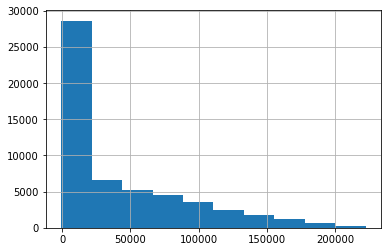

In [168]:
data_train["AMT_BALANCE"].hist()

In [169]:
data_train = data_train.drop(["AMT_BALANCE", "AMT_CREDIT_LIMIT_ACTUAL", "Ratio_Credit_limit"], axis = 1)

In [170]:
tot = data_train[data_train["previous_CREDIT"].isna()]["TARGET"].shape[0]
bad = data_train[data_train["previous_CREDIT"].isna()]["TARGET"].sum()
#Bad loan proportion present in the 11.77% NaN 
bad/tot

0.07652198421645998

In [171]:
#bad proportion will be deleted
bad/data_train[["TARGET"]].sum()

TARGET    0.081462
dtype: float64

In [172]:
ind = data_train["previous_CREDIT"].isna()
data_train.loc[ind, "previous_CREDIT"] = 0
data_train.loc[ind, "ratio_ask_get"] = 0

In [173]:
for col in data_train.columns:
    tmp = data_train[col].isnull().sum()
    if tmp > 0:
        print(col+" {0:.2f}%".format(data_train[col].isnull().sum()/data_train[col].shape[0] *100))

CREDIT_active 43.08%


In [174]:
data_train.shape

(216219, 54)

In [175]:
data_train = data_train.dropna()

In [176]:
for col in data_train.columns:
    tmp = np.isinf(data_train[col]).values.sum()
    if tmp > 0:
        print(col)

proportion_OVERDUE_active
proportion_OVERDUE_closed
ratio_ask_get


In [177]:
data_train.loc[np.isinf(data_train["proportion_OVERDUE_active"]), ["proportion_OVERDUE_active", "CREDIT_active", "CREDIT_MEAN_active"]]

,proportion_OVERDUE_active,CREDIT_active,CREDIT_MEAN_active
5227,inf,1.0,0.0
44576,inf,1.0,0.0
47190,inf,1.0,0.0
47451,inf,1.0,0.0
66490,inf,1.0,0.0
69838,inf,1.0,0.0
78399,inf,1.0,0.0
96612,inf,1.0,0.0
111852,inf,1.0,0.0
128744,inf,1.0,0.0


In [178]:
data_train.loc[np.isinf(data_train["proportion_OVERDUE_active"]), ["proportion_OVERDUE_active"]] = 0

In [179]:
data_train.head(3)

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AGE,YEARS_EMPLOYED,OWN_CAR_AGE,CNT_FAM_MEMBERS,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Other,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Other,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,CREDIT_active,CREDIT_MEAN_OVERDUE_active,CREDIT_MEAN_active,proportion_OVERDUE_active,CREDIT_sold,CREDIT_MEAN_OVERDUE_sold,CREDIT_MEAN_sold,proportion_OVERDUE_sold,CREDIT_closed,CREDIT_MEAN_OVERDUE_closed,CREDIT_MEAN_closed,proportion_OVERDUE_closed,CREDIT_bad,CREDIT_MEAN_OVERDUE_bad,CREDIT_MEAN_bad,proportion_OVERDUE_bad,previous_CREDIT,ratio_ask_get,Number_years_Loan_Theorical,AMT_CREDIT_ANNUITY_RATIO
0,100002,1,202500.0,406597.5,24700.5,25.956104,1.747599,0.0,1.0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1.0,0.0,450000.0,0.0,0.0,0.0,0.0,0.0,1.0,2091.16125,76613.400000,0.027295,0.0,0.0,0.0,0.0,179055.000000,1.000000,0.121978,16.461104
5,100008,0,99000.0,490495.5,27517.5,46.477366,4.356653,0.0,2.0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1.0,0.0,267606.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00000,100419.750000,0.000000,0.0,0.0,0.0,0.0,162767.700000,1.045381,0.277955,17.824857
6,100009,0,171000.0,1560726.0,41301.0,37.799726,8.587106,17.0,3.0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2.0,0.0,490180.5,0.0,0.0,0.0,0.0,0.0,1.0,0.00000,115057.730769,0.000000,0.0,0.0,0.0,0.0,70137.642857,0.913944,0.241526,37.789061


In [180]:
data_train.loc[np.isinf(data_train["proportion_OVERDUE_closed"]), ["proportion_OVERDUE_closed", "CREDIT_closed", "CREDIT_MEAN_closed"]]

,proportion_OVERDUE_closed,CREDIT_closed,CREDIT_MEAN_closed
27785,inf,1.0,0.0
34735,inf,1.0,0.0
55619,inf,1.0,0.0
59168,inf,1.0,0.0
62663,inf,1.0,0.0
102348,inf,1.0,0.0
109097,inf,1.0,0.0
113636,inf,1.0,0.0
143063,inf,1.0,0.0
148639,inf,1.0,0.0


In [181]:
data_train.loc[np.isinf(data_train["proportion_OVERDUE_closed"]), ["proportion_OVERDUE_closed"]] = 0

In [182]:
data_train.loc[np.isinf(data_train["ratio_ask_get"]), ["TARGET"]].sum()

TARGET    27
dtype: int64

In [183]:
data_train.loc[np.isinf(data_train["ratio_ask_get"]), ["ratio_ask_get"]] = np.nan

In [184]:
data_train = data_train.dropna()

In [185]:
data_clean1 = data_train.drop(['AMT_CREDIT', 'Number_years_Loan_Theorical', 'AMT_CREDIT_ANNUITY_RATIO', 'ratio_ask_get'], axis = 1)
data_clean1.to_csv("clean_data.csv", index=False)

In [186]:
data_train = data_train.drop(['AMT_CREDIT', 'ratio_ask_get'], axis = 1)
data_train.to_csv("clean_data1.csv", index=False)